In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Project Data Mining/Predicting Coupon Redemption/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Project Data Mining/Predicting Coupon Redemption/test.csv")
demographics = pd.read_csv("/content/drive/MyDrive/Project Data Mining/Predicting Coupon Redemption/customer_demographics.csv")
transaction = pd.read_csv("/content/drive/MyDrive/Project Data Mining/Predicting Coupon Redemption/customer_transaction_data.csv", parse_dates=['date'])
coupon_item = pd.read_csv("/content/drive/MyDrive/Project Data Mining/Predicting Coupon Redemption/coupon_item_mapping.csv")
item = pd.read_csv("/content/drive/MyDrive/Project Data Mining/Predicting Coupon Redemption/item_data.csv")
campaign = pd.read_csv("/content/drive/MyDrive/Project Data Mining/Predicting Coupon Redemption/campaign_data.csv", parse_dates=['start_date','end_date'])

# 1. Campaign

In [ ]:
for index, row in campaign.iterrows():
  if row.end_date < row.start_date:
    campaign.iloc[index, 2] = row.end_date
    campaign.iloc[index, 3] = row.start_date

campaign['duration_days'] = (campaign['end_date'] - campaign['start_date']).dt.days

campaign['start_year'] = campaign['start_date'].dt.year
campaign['start_quarter'] = campaign.start_date.dt.quarter
campaign['start_month'] = campaign.start_date.dt.month
campaign['start_week'] = campaign.start_date.dt.isocalendar().week
campaign['start_day'] = campaign.start_date.dt.day
campaign['start_weekday'] = campaign.start_date.dt.weekday

campaign['end_year'] = campaign['end_date'].dt.year
campaign['end_quarter'] =  campaign.end_date.dt.quarter
campaign['end_month'] = campaign.end_date.dt.month
campaign['end_week'] =  campaign.end_date.dt.isocalendar().week
campaign['end_day'] = campaign.end_date.dt.day
campaign['end_weekday'] =  campaign.end_date.dt.weekday

camp = campaign.drop(columns=['start_date', 'end_date'])

for col in camp.columns[2:]:
  if col == 'start_year' or col == 'end_year':
    camp[f'camp_{col}'] = camp[col].astype('category')
  else:
    camp[f'camp_{col}'] = camp[col]
  camp.drop(columns=col, inplace=True)

camp.campaign_type = camp.campaign_type.astype('category')

In [ ]:
camp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   campaign_id         28 non-null     int64   
 1   campaign_type       28 non-null     category
 2   camp_duration_days  28 non-null     int64   
 3   camp_start_year     28 non-null     category
 4   camp_start_quarter  28 non-null     int64   
 5   camp_start_month    28 non-null     int64   
 6   camp_start_week     28 non-null     UInt32  
 7   camp_start_day      28 non-null     int64   
 8   camp_start_weekday  28 non-null     int64   
 9   camp_end_year       28 non-null     category
 10  camp_end_quarter    28 non-null     int64   
 11  camp_end_month      28 non-null     int64   
 12  camp_end_week       28 non-null     UInt32  
 13  camp_end_day        28 non-null     int64   
 14  camp_end_weekday    28 non-null     int64   
dtypes: UInt32(2), category(3), int64(10)
memor

In [ ]:
print(train.campaign_id.isin(camp.campaign_id).all())
print(test.campaign_id.isin(camp.campaign_id).all())

True
True


#2. Coupon

## dataset: item

In [ ]:
coupon_item_ = coupon_item.merge(item, on='item_id', how='left').dropna()
coupon_item_

,coupon_id,item_id,brand,brand_type,category
0,105,37,56,Local,Grocery
1,107,75,56,Local,Grocery
2,494,76,209,Established,Grocery
3,522,77,278,Established,Grocery
4,518,77,278,Established,Grocery
...,...,...,...,...,...
92658,32,69268,686,Established,Pharmaceutical
92659,32,68502,1009,Established,Pharmaceutical
92660,32,68612,1104,Established,Pharmaceutical
92661,33,71390,4196,Established,Meat


In [ ]:
d = coupon_item_.groupby('coupon_id')['item_id'].value_counts()
print(d[d>1])

d = coupon_item_.groupby('coupon_id')['brand'].value_counts().rename('brand_count').reset_index()
d = d.merge(d.groupby('coupon_id').agg(sum=('brand_count','sum')).reset_index(), on='coupon_id', how='left')
d['relative_frequency'] = d['brand_count'] / d['sum']
d

Series([], Name: item_id, dtype: int64)


,coupon_id,brand,brand_count,sum,relative_frequency
0,1,1475,25,39,0.641026
1,1,1558,9,39,0.230769
2,1,4700,5,39,0.128205
3,2,2084,2,2,1.000000
4,3,278,12,17,0.705882
...,...,...,...,...,...
7871,1112,5177,6,6,1.000000
7872,1113,5184,15,15,1.000000
7873,1114,2416,3,3,1.000000
7874,1115,2446,7,7,1.000000


In [ ]:
ind = d.groupby('coupon_id')['relative_frequency'].nlargest(1).reset_index(level=0).index
mf = d.iloc[ind,:].drop(columns=['brand_count','sum'])
mf

,coupon_id,brand,relative_frequency
0,1,1475,0.641026
3,2,2084,1.000000
4,3,278,0.705882
6,4,544,1.000000
7,5,5357,1.000000
...,...,...,...
7871,1112,5177,1.000000
7872,1113,5184,1.000000
7873,1114,2416,1.000000
7874,1115,2446,1.000000


In [ ]:
def gini_index(x):
  return 1- sum(np.square(x))
gini = d.groupby('coupon_id').agg(coup_brand_gini=('relative_frequency', gini_index)).reset_index()
gini

,coupon_id,coup_brand_gini
0,1,0.519395
1,2,0.000000
2,3,0.415225
3,4,0.000000
4,5,0.000000
...,...,...
1111,1112,0.000000
1112,1113,0.000000
1113,1114,0.000000
1114,1115,0.000000


In [ ]:
coup_1 = coupon_item_.groupby('coupon_id').agg(coup_nitem=('item_id','nunique'), coup_nbrand=('brand','nunique'))
coup_1 = coup_1.reset_index().merge(mf, on='coupon_id', validate='one_to_one')
coup_1 = coup_1.rename(columns={'brand':'coup_mfbrand','relative_frequency':'coup_mfbrand_rf'})
coup_1 = coup_1.merge(gini, on='coupon_id', validate='one_to_one')
coup_1 = coup_1.merge(item.iloc[:, 1:3].drop_duplicates(), left_on='coup_mfbrand', right_on='brand', how='left').drop(columns=['brand', 'coup_mfbrand']).rename(columns={'brand_type':'coup_mfbrand_type'})
coup_1['coup_mfbrand_type'] = coup_1['coup_mfbrand_type'].astype('category')
coup_1

,coupon_id,coup_nitem,coup_nbrand,coup_mfbrand_rf,coup_brand_gini,coup_mfbrand_type
0,1,39,3,0.641026,0.519395,Established
1,2,2,1,1.000000,0.000000,Established
2,3,17,2,0.705882,0.415225,Established
3,4,24,1,1.000000,0.000000,Established
4,5,7,1,1.000000,0.000000,Established
...,...,...,...,...,...,...
1111,1112,6,1,1.000000,0.000000,Established
1112,1113,15,1,1.000000,0.000000,Established
1113,1114,3,1,1.000000,0.000000,Established
1114,1115,7,1,1.000000,0.000000,Established


In [ ]:
btype = coupon_item_.groupby('coupon_id')['brand_type'].value_counts().rename('brand_type_count').reset_index()
btype = btype.pivot_table(index=['coupon_id'], columns=['brand_type'], values=['brand_type_count'])
btype = btype.fillna(0)
btype

brand_type_count      
brand_type      Established Local
coupon_id                        
1                      39.0   0.0
2                       2.0   0.0
3                      17.0   0.0
4                      24.0   0.0
5                       7.0   0.0
...                     ...   ...
1112                    6.0   0.0
1113                   15.0   0.0
1114                    3.0   0.0
1115                    7.0   0.0
1116                    2.0   0.0

[1116 rows x 2 columns]

In [ ]:
cate = coupon_item_.groupby('coupon_id')['category'].value_counts().rename('category_count').reset_index()
cate = cate.pivot_table(index=['coupon_id'], columns=['category'], values=['category_count'])
cate = cate.dropna(axis=1, how='all').fillna(0)
cate

category_count                                                 \
category          Bakery Dairy, Juices & Snacks Flowers & Plants Garden   
coupon_id                                                                 
1                    0.0                    0.0              0.0    0.0   
2                    0.0                    0.0              0.0    0.0   
3                    0.0                    0.0              0.0    0.0   
4                    0.0                    0.0              0.0    0.0   
5                    0.0                    0.0              0.0    0.0   
...                  ...                    ...              ...    ...   
1112                 0.0                    0.0              0.0    0.0   
1113                 0.0                    0.0              0.0    0.0   
1114                 0.0                    0.0              0.0    0.0   
1115                 0.0                    0.0              0.0    0.0   
1116                 0.0                    0.0              0.0    0.0   

                                                                     \
category  Grocery Meat Miscellaneous Natural Products Packaged Meat   
coupon_id                                                             
1             9.0  0.0           0.0             30.0           0.0   
2             2.0  0.0           0.0              0.0           0.0   
3            17.0  0.0           0.0              0.0           0.0   
4            24.0  0.0           0.0              0.0           0.0   
5             0.0  0.0           0.0              0.0           0.0   
...           ...  ...           ...              ...           ...   
1112          6.0  0.0           0.0              0.0           0.0   
1113          0.0  0.0           0.0              0.0           0.0   
1114          0.0  0.0           0.0              0.0           0.0   
1115          7.0  0.0           0.0              0.0           0.0   
1116          0.0  0.0           0.0              0.0           0.0   

                                                                   \
category  Pharmaceutical Prepared Food Restauarant Salads Seafood   
coupon_id                                                           
1                    0.0           0.0         0.0    0.0     0.0   
2                    0.0           0.0         0.0    0.0     0.0   
3                    0.0           0.0         0.0    0.0     0.0   
4                    0.0           0.0         0.0    0.0     0.0   
5                    7.0           0.0         0.0    0.0     0.0   
...                  ...           ...         ...    ...     ...   
1112                 0.0           0.0         0.0    0.0     0.0   
1113                15.0           0.0         0.0    0.0     0.0   
1114                 3.0           0.0         0.0    0.0     0.0   
1115                 0.0           0.0         0.0    0.0     0.0   
1116                 2.0           0.0         0.0    0.0     0.0   

                                                    
category  Skin & Hair Care Travel Vegetables (cut)  
coupon_id                                           
1                      0.0    0.0              0.0  
2                      0.0    0.0              0.0  
3                      0.0    0.0              0.0  
4                      0.0    0.0              0.0  
5                      0.0    0.0              0.0  
...                    ...    ...              ...  
1112                   0.0    0.0              0.0  
1113                   0.0    0.0              0.0  
1114                   0.0    0.0              0.0  
1115                   0.0    0.0              0.0  
1116                   0.0    0.0              0.0  

[1116 rows x 17 columns]

In [ ]:
bc = btype.merge(cate, on='coupon_id', validate='one_to_one')

for col in btype.columns:
  bc[f'coup_brand_{col[1]}'] = bc[col]
  bc = bc.drop(columns=col)

for col in cate.columns:
  if col[1] == 'Vegetables (cut)':
    s = 'cutVegetables'
  else:
    s = col[1]
    s = s.replace(" ","").replace(',', '').replace('&','')
  
  bc[f'coup_{s}'] = bc[col]
  bc = bc.drop(columns=col)

bc.columns = bc.columns.droplevel(1)

In [ ]:
coup_1 = coup_1.merge(bc, on='coupon_id', validate='one_to_one')

In [ ]:
coup_1

,coupon_id,coup_nitem,coup_nbrand,coup_mfbrand_rf,coup_brand_gini,coup_mfbrand_type,coup_brand_Established,coup_brand_Local,coup_Bakery,coup_DairyJuicesSnacks,...,coup_NaturalProducts,coup_PackagedMeat,coup_Pharmaceutical,coup_PreparedFood,coup_Restauarant,coup_Salads,coup_Seafood,coup_SkinHairCare,coup_Travel,coup_cutVegetables
0,1,39,3,0.641026,0.519395,Established,39.0,0.0,0.0,0.0,...,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,2,1,1.000000,0.000000,Established,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,17,2,0.705882,0.415225,Established,17.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,24,1,1.000000,0.000000,Established,24.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,7,1,1.000000,0.000000,Established,7.0,0.0,0.0,0.0,...,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111,1112,6,1,1.000000,0.000000,Established,6.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1112,1113,15,1,1.000000,0.000000,Established,15.0,0.0,0.0,0.0,...,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1113,1114,3,1,1.000000,0.000000,Established,3.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1114,1115,7,1,1.000000,0.000000,Established,7.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
coup_1.columns

Index(['coupon_id', 'coup_nitem', 'coup_nbrand', 'coup_mfbrand_rf',
       'coup_brand_gini', 'coup_mfbrand_type', 'coup_brand_Established',
       'coup_brand_Local', 'coup_Bakery', 'coup_DairyJuicesSnacks',
       'coup_FlowersPlants', 'coup_Garden', 'coup_Grocery', 'coup_Meat',
       'coup_Miscellaneous', 'coup_NaturalProducts', 'coup_PackagedMeat',
       'coup_Pharmaceutical', 'coup_PreparedFood', 'coup_Restauarant',
       'coup_Salads', 'coup_Seafood', 'coup_SkinHairCare', 'coup_Travel',
       'coup_cutVegetables'],
      dtype='object')

## dataset transaction

In [ ]:
trans = transaction.groupby(['date','customer_id','item_id'])[['quantity','selling_price','other_discount','coupon_discount']].sum().reset_index()
trans['original_selling_price'] = trans['selling_price'] - trans['other_discount'] - trans['coupon_discount']
trans['original_unit_price'] = trans['original_selling_price'] / trans['quantity']
trans

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount,original_selling_price,original_unit_price
0,2012-01-02,67,10537,3,32.06,0.00,0.00,32.06,10.686667
1,2012-01-02,67,19560,2,106.86,-2.85,0.00,109.71,54.855000
2,2012-01-02,67,21653,1,44.52,-12.11,0.00,56.63,56.630000
3,2012-01-02,67,32083,1,8.90,0.00,0.00,8.90,8.900000
4,2012-01-02,135,4642,1,44.52,-12.11,0.00,56.63,56.630000
...,...,...,...,...,...,...,...,...,...
1320382,2013-07-03,1558,32271,2,47.73,-8.55,0.00,56.28,28.140000
1320383,2013-07-03,1558,36961,3,106.86,-102.59,0.00,209.45,69.816667
1320384,2013-07-03,1558,50180,1,23.51,-4.63,0.00,28.14,28.140000
1320385,2013-07-03,1558,64114,2,71.24,-20.66,0.00,91.90,45.950000


In [ ]:
items = trans.set_index(['date','customer_id'])['item_id'].value_counts().rename('item_ntransaction')
items.index.name = 'item_id'
items = items.reset_index()

now = trans.date.max()
items = items.merge(trans.groupby('item_id')['date'].max().apply(lambda x: now-x).dt.days.rename('item_recency_days'), on='item_id', validate='one_to_one')
items = items.merge((trans.groupby('item_id')['date'].max()-trans.groupby('item_id')['date'].min()).dt.days.rename('item_life_days'), on='item_id', validate='one_to_one')
items = items.merge(trans.groupby('item_id')['customer_id'].nunique().rename('item_popularity'), on='item_id', validate='one_to_one')
items

,item_id,item_ntransaction,item_recency_days,item_life_days,item_popularity
0,49009,13257,0,537,919
1,34047,6161,0,548,675
2,13174,3863,0,548,905
3,45502,3265,0,548,685
4,29847,2261,0,540,531
...,...,...,...,...,...
74058,67815,1,303,0,1
74059,17545,1,303,0,1
74060,64823,1,303,0,1
74061,63939,1,303,0,1


In [ ]:
items = items.merge(trans.groupby('item_id')['quantity'].sum().rename('item_tot_quantity'), on='item_id', validate='one_to_one')
items = items.merge(trans.groupby('item_id')['quantity'].mean().rename('item_avg_quantity'), on='item_id', validate='one_to_one')
items = items.merge(trans.groupby('item_id')['quantity'].min().rename('item_min_quantity'), on='item_id', validate='one_to_one')
items = items.merge(trans.groupby('item_id')['quantity'].max().rename('item_max_quantity'), on='item_id', validate='one_to_one')

items = items.merge(trans.groupby('item_id')['selling_price'].sum().rename('item_tot_sales_value'), on='item_id', validate='one_to_one')
items = items.merge(trans.groupby('item_id')['selling_price'].mean().rename('item_avg_sales_value'), on='item_id', validate='one_to_one')
items = items.merge(trans.groupby('item_id')['selling_price'].min().rename('item_min_sales_value'), on='item_id', validate='one_to_one')
items = items.merge(trans.groupby('item_id')['selling_price'].max().rename('item_max_sales_value'), on='item_id', validate='one_to_one')

items = items.merge(trans.groupby('item_id')['other_discount'].sum().rename('item_tot_other_discount'), on='item_id', validate='one_to_one')
items = items.merge(trans.groupby('item_id')['other_discount'].mean().rename('item_avg_other_discount'), on='item_id', validate='one_to_one')
items = items.merge(trans.groupby('item_id')['other_discount'].min().rename('item_min_other_discount'), on='item_id', validate='one_to_one')
items = items.merge(trans.groupby('item_id')['other_discount'].max().rename('item_max_other_discount'), on='item_id', validate='one_to_one')

items = items.merge(trans.groupby('item_id')['coupon_discount'].sum().rename('item_tot_coupon_discount'), on='item_id', validate='one_to_one')
items = items.merge(trans.groupby('item_id')['coupon_discount'].mean().rename('item_avg_coupon_discount'), on='item_id', validate='one_to_one')
items = items.merge(trans.groupby('item_id')['coupon_discount'].min().rename('item_min_coupon_discount'), on='item_id', validate='one_to_one')
items = items.merge(trans.groupby('item_id')['coupon_discount'].max().rename('item_max_coupon_discount'), on='item_id', validate='one_to_one')

items = items.merge(trans.groupby('item_id')['original_unit_price'].mean().rename('item_avg_unit_price'), on='item_id', validate='one_to_one')
items = items.merge(trans.groupby('item_id')['original_unit_price'].min().rename('item_min_unit_price'), on='item_id', validate='one_to_one')
items = items.merge(trans.groupby('item_id')['original_unit_price'].max().rename('item_max_unit_price'), on='item_id', validate='one_to_one')
items

,item_id,item_ntransaction,item_recency_days,item_life_days,item_popularity,item_tot_quantity,item_avg_quantity,item_min_quantity,item_max_quantity,item_tot_sales_value,...,item_avg_other_discount,item_min_other_discount,item_max_other_discount,item_tot_coupon_discount,item_avg_coupon_discount,item_min_coupon_discount,item_max_coupon_discount,item_avg_unit_price,item_min_unit_price,item_max_unit_price
0,49009,13257,0,537,919,147200033,11103.570416,16,122583,12609878.84,...,-31.599679,-540.36,0.00,0.00,0.000000,0.00,0.0,0.088749,0.062661,0.113982
1,34047,6161,0,548,675,7383,1.198344,1,7,626378.04,...,-5.628051,-205.17,0.00,-901.51,-0.146325,-89.76,0.0,89.794314,53.430000,179.520000
2,13174,3863,0,548,905,4287,1.109759,1,19,150290.13,...,-0.217574,-42.74,0.00,0.00,0.000000,0.00,0.0,35.252032,24.580000,35.270000
3,45502,3265,0,548,685,5396,1.652680,1,52,584930.72,...,-96.612873,-1560.16,0.00,-17381.49,-5.323580,-334.12,0.0,168.455794,106.860000,334.120000
4,29847,2261,0,540,531,3608,1.595754,1,10,128047.23,...,-12.966471,-174.54,0.00,-233.33,-0.103198,-35.62,0.0,43.888493,34.550000,70.885000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74058,67815,1,303,0,1,1,1.000000,1,1,712.04,...,0.000000,0.00,0.00,0.00,0.000000,0.00,0.0,712.040000,712.040000,712.040000
74059,17545,1,303,0,1,1,1.000000,1,1,150.32,...,-100.450000,-100.45,-100.45,0.00,0.000000,0.00,0.0,250.770000,250.770000,250.770000
74060,64823,1,303,0,1,3,3.000000,3,3,106.86,...,0.000000,0.00,0.00,0.00,0.000000,0.00,0.0,35.620000,35.620000,35.620000
74061,63939,1,303,0,1,1,1.000000,1,1,37.76,...,-18.520000,-18.52,-18.52,0.00,0.000000,0.00,0.0,56.280000,56.280000,56.280000


In [ ]:
coup_items = coupon_item.merge(items, on='item_id', how='left').dropna()
coup_items

,coupon_id,item_id,item_ntransaction,item_recency_days,item_life_days,item_popularity,item_tot_quantity,item_avg_quantity,item_min_quantity,item_max_quantity,...,item_avg_other_discount,item_min_other_discount,item_max_other_discount,item_tot_coupon_discount,item_avg_coupon_discount,item_min_coupon_discount,item_max_coupon_discount,item_avg_unit_price,item_min_unit_price,item_max_unit_price
0,105,37,7.0,96.0,383.0,2.0,16.0,2.285714,1.0,3.0,...,-17.557143,-33.84,0.00,0.0,0.0,0.0,0.0,57.247381,56.635,58.773333
1,107,75,33.0,20.0,443.0,4.0,45.0,1.363636,1.0,4.0,...,-5.159394,-45.59,0.00,0.0,0.0,0.0,0.0,38.828485,38.825,38.830000
2,494,76,1.0,311.0,0.0,1.0,1.0,1.000000,1.0,1.0,...,-17.450000,-17.45,-17.45,0.0,0.0,0.0,0.0,106.500000,106.500,106.500000
3,522,77,2.0,74.0,204.0,2.0,2.0,1.000000,1.0,1.0,...,-16.920000,-33.84,0.00,0.0,0.0,0.0,0.0,87.270000,87.270,87.270000
4,518,77,2.0,74.0,204.0,2.0,2.0,1.000000,1.0,1.0,...,-16.920000,-33.84,0.00,0.0,0.0,0.0,0.0,87.270000,87.270,87.270000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92658,32,69268,2.0,40.0,13.0,2.0,2.0,1.000000,1.0,1.0,...,-35.620000,-35.62,-35.62,0.0,0.0,0.0,0.0,355.840000,355.840,355.840000
92659,32,68502,1.0,99.0,0.0,1.0,1.0,1.000000,1.0,1.0,...,0.000000,0.00,0.00,0.0,0.0,0.0,0.0,355.840000,355.840,355.840000
92660,32,68612,1.0,123.0,0.0,1.0,1.0,1.000000,1.0,1.0,...,0.000000,0.00,0.00,0.0,0.0,0.0,0.0,169.200000,169.200,169.200000
92661,33,71390,2.0,55.0,105.0,2.0,2.0,1.000000,1.0,1.0,...,0.000000,0.00,0.00,0.0,0.0,0.0,0.0,255.575000,247.560,263.590000


In [ ]:
coup_2 = coupon_item['coupon_id'].drop_duplicates().sort_values()
coup_2 = coup_2.reset_index(drop=True).to_frame()

for col in coup_items.columns[2:]:
  for func in ['min', 'max', 'mean', 'std']:
    coup_2 = coup_2.merge(coup_items.groupby('coupon_id').agg({col:func}).rename(columns={col:f'coup_{col}_{func}'}), on='coupon_id', validate='one_to_one')

coup_2 = coup_2.fillna(0)

In [ ]:
coup_2.columns

Index(['coupon_id', 'coup_item_ntransaction_min', 'coup_item_ntransaction_max',
       'coup_item_ntransaction_mean', 'coup_item_ntransaction_std',
       'coup_item_recency_days_min', 'coup_item_recency_days_max',
       'coup_item_recency_days_mean', 'coup_item_recency_days_std',
       'coup_item_life_days_min', 'coup_item_life_days_max',
       'coup_item_life_days_mean', 'coup_item_life_days_std',
       'coup_item_popularity_min', 'coup_item_popularity_max',
       'coup_item_popularity_mean', 'coup_item_popularity_std',
       'coup_item_tot_quantity_min', 'coup_item_tot_quantity_max',
       'coup_item_tot_quantity_mean', 'coup_item_tot_quantity_std',
       'coup_item_avg_quantity_min', 'coup_item_avg_quantity_max',
       'coup_item_avg_quantity_mean', 'coup_item_avg_quantity_std',
       'coup_item_min_quantity_min', 'coup_item_min_quantity_max',
       'coup_item_min_quantity_mean', 'coup_item_min_quantity_std',
       'coup_item_max_quantity_min', 'coup_item_max_quantity_m

In [ ]:
coup = coup_1.merge(coup_2, on='coupon_id', validate='one_to_one')

In [ ]:
coup

,coupon_id,coup_nitem,coup_nbrand,coup_mfbrand_rf,coup_brand_gini,coup_mfbrand_type,coup_brand_Established,coup_brand_Local,coup_Bakery,coup_DairyJuicesSnacks,...,coup_item_avg_unit_price_mean,coup_item_avg_unit_price_std,coup_item_min_unit_price_min,coup_item_min_unit_price_max,coup_item_min_unit_price_mean,coup_item_min_unit_price_std,coup_item_max_unit_price_min,coup_item_max_unit_price_max,coup_item_max_unit_price_mean,coup_item_max_unit_price_std
0,1,39,3,0.641026,0.519395,Established,39.0,0.0,0.0,0.0,...,101.862862,24.887360,35.260,124.31,96.756923,28.512727,53.07,213.360,110.165641,32.828031
1,2,2,1,1.000000,0.000000,Established,2.0,0.0,0.0,0.0,...,122.534500,17.628879,110.065,135.00,122.532500,17.631708,110.07,135.000,122.535000,17.628172
2,3,17,2,0.705882,0.415225,Established,17.0,0.0,0.0,0.0,...,134.120333,6.639327,101.160,135.00,129.970000,8.835257,124.67,188.430,151.865882,18.970620
3,4,24,1,1.000000,0.000000,Established,24.0,0.0,0.0,0.0,...,213.184245,14.251253,106.860,248.98,201.294167,30.162634,195.55,248.980,217.814375,17.614855
4,5,7,1,1.000000,0.000000,Established,7.0,0.0,0.0,0.0,...,403.970000,137.784172,305.970,605.18,402.654286,138.742124,320.22,605.180,405.200000,136.915548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111,1112,6,1,1.000000,0.000000,Established,6.0,0.0,0.0,0.0,...,165.658229,16.442501,135.000,170.62,161.120000,15.390834,135.00,184.870,171.805833,18.255183
1112,1113,15,1,1.000000,0.000000,Established,15.0,0.0,0.0,0.0,...,125.974125,82.089783,70.880,248.98,125.973000,82.090360,70.88,248.985,125.975933,82.089800
1113,1114,3,1,1.000000,0.000000,Established,3.0,0.0,0.0,0.0,...,611.116667,131.279555,462.700,712.04,611.116667,131.279555,462.70,712.040,611.116667,131.279555
1114,1115,7,1,1.000000,0.000000,Established,7.0,0.0,0.0,0.0,...,256.361761,34.506719,209.800,284.60,245.215714,32.519421,224.05,355.840,279.817143,45.877320


In [ ]:
coup.select_dtypes(include=["category"]).nunique()

coup_mfbrand_type    2
dtype: int64

# 3. Customer


In [ ]:
trans = trans.rename(columns={'selling_price':'expense','original_selling_price':'original_expense','original_unit_price':'original_expense_peritem'})
trans['expense_peritem'] = trans['expense'] /trans['quantity']
trans['other_discount_peritem'] = trans['other_discount'] /trans['quantity']
trans['coupon_discount_peritem'] = trans['coupon_discount'] /trans['quantity']
trans

,date,customer_id,item_id,quantity,expense,other_discount,coupon_discount,original_expense,original_expense_peritem,expense_peritem,other_discount_peritem,coupon_discount_peritem
0,2012-01-02,67,10537,3,32.06,0.00,0.00,32.06,10.686667,10.686667,0.000000,0.00
1,2012-01-02,67,19560,2,106.86,-2.85,0.00,109.71,54.855000,53.430000,-1.425000,0.00
2,2012-01-02,67,21653,1,44.52,-12.11,0.00,56.63,56.630000,44.520000,-12.110000,0.00
3,2012-01-02,67,32083,1,8.90,0.00,0.00,8.90,8.900000,8.900000,0.000000,0.00
4,2012-01-02,135,4642,1,44.52,-12.11,0.00,56.63,56.630000,44.520000,-12.110000,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
1320382,2013-07-03,1558,32271,2,47.73,-8.55,0.00,56.28,28.140000,23.865000,-4.275000,0.00
1320383,2013-07-03,1558,36961,3,106.86,-102.59,0.00,209.45,69.816667,35.620000,-34.196667,0.00
1320384,2013-07-03,1558,50180,1,23.51,-4.63,0.00,28.14,28.140000,23.510000,-4.630000,0.00
1320385,2013-07-03,1558,64114,2,71.24,-20.66,0.00,91.90,45.950000,35.620000,-10.330000,0.00


In [ ]:
trans_item = trans.merge(item, on='item_id', how='left')
trans_item

,date,customer_id,item_id,quantity,expense,other_discount,coupon_discount,original_expense,original_expense_peritem,expense_peritem,other_discount_peritem,coupon_discount_peritem,brand,brand_type,category
0,2012-01-02,67,10537,3,32.06,0.00,0.00,32.06,10.686667,10.686667,0.000000,0.00,487,Established,Grocery
1,2012-01-02,67,19560,2,106.86,-2.85,0.00,109.71,54.855000,53.430000,-1.425000,0.00,56,Local,Grocery
2,2012-01-02,67,21653,1,44.52,-12.11,0.00,56.63,56.630000,44.520000,-12.110000,0.00,56,Local,Grocery
3,2012-01-02,67,32083,1,8.90,0.00,0.00,8.90,8.900000,8.900000,0.000000,0.00,487,Established,Grocery
4,2012-01-02,135,4642,1,44.52,-12.11,0.00,56.63,56.630000,44.520000,-12.110000,0.00,56,Local,Grocery
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1320382,2013-07-03,1558,32271,2,47.73,-8.55,0.00,56.28,28.140000,23.865000,-4.275000,0.00,56,Local,Grocery
1320383,2013-07-03,1558,36961,3,106.86,-102.59,0.00,209.45,69.816667,35.620000,-34.196667,0.00,1636,Established,Grocery
1320384,2013-07-03,1558,50180,1,23.51,-4.63,0.00,28.14,28.140000,23.510000,-4.630000,0.00,56,Local,Grocery
1320385,2013-07-03,1558,64114,2,71.24,-20.66,0.00,91.90,45.950000,35.620000,-10.330000,0.00,1337,Established,Grocery


In [ ]:
d = trans_item.groupby('customer_id')['item_id'].value_counts().rename('frequency').reset_index()
d = d.merge(d.groupby('customer_id')['frequency'].sum().rename('total_frequency'), on='customer_id', how='left')
d['relative_frequency'] = d['frequency'] / d['total_frequency']
d

,customer_id,item_id,frequency,total_frequency,relative_frequency
0,1,8307,44,1046,0.042065
1,1,57921,27,1046,0.025813
2,1,17047,23,1046,0.021989
3,1,28276,21,1046,0.020076
4,1,45986,18,1046,0.017208
...,...,...,...,...,...
787682,1582,72789,1,845,0.001183
787683,1582,72892,1,845,0.001183
787684,1582,73095,1,845,0.001183
787685,1582,73781,1,845,0.001183


In [ ]:
cust = trans.customer_id.drop_duplicates()
cust = cust.sort_values().reset_index(drop=True).to_frame()
cust = cust.merge(trans.groupby('customer_id')['date'].nunique().rename('cust_nvisit'), on='customer_id', validate='one_to_one')
cust = cust.merge((trans.groupby('customer_id')['date'].max()-trans.groupby('customer_id')['date'].min()).dt.days.rename('cust_span_days'), on='customer_id', validate='one_to_one')
cust = cust.merge(trans.groupby('customer_id')['date'].max().apply(lambda x: (now-x)).dt.days.rename('cust_recency_days'), on='customer_id', validate='one_to_one')
cust = cust.merge(trans.groupby('customer_id')['item_id'].nunique().rename('cust_item_variety'), on='customer_id', validate='one_to_one')

cust

,customer_id,cust_nvisit,cust_span_days,cust_recency_days,cust_item_variety
0,1,56,495,3,463
1,2,37,439,7,352
2,3,41,419,17,406
3,4,26,392,53,125
4,5,163,427,4,490
...,...,...,...,...,...
1577,1578,37,412,20,481
1578,1579,149,470,1,639
1579,1580,100,442,2,422
1580,1581,59,474,5,390


In [ ]:
ind = d.groupby('customer_id')['relative_frequency'].nlargest(1).reset_index(0).index
cust = cust.merge(d.loc[ind, ['customer_id','item_id','relative_frequency']].reset_index(drop=True), on='customer_id', validate='one_to_one')
cust = cust.rename(columns={'item_id':'cust_mfitem', 'relative_frequency':'cust_mfitem_rf'})
cust = cust.merge(d.groupby('customer_id').agg(cust_item_gini=('relative_frequency', gini_index)), on='customer_id', validate='one_to_one')
cust

,customer_id,cust_nvisit,cust_span_days,cust_recency_days,cust_item_variety,cust_mfitem,cust_mfitem_rf,cust_item_gini
0,1,56,495,3,463,8307,0.042065,0.992615
1,2,37,439,7,352,34047,0.016706,0.996224
2,3,41,419,17,406,32573,0.028369,0.994702
3,4,26,392,53,125,47968,0.050000,0.985992
4,5,163,427,4,490,35304,0.051768,0.993454
...,...,...,...,...,...,...,...,...
1577,1578,37,412,20,481,45502,0.017903,0.996003
1578,1579,149,470,1,639,19628,0.018966,0.995746
1579,1580,100,442,2,422,19418,0.009452,0.997009
1580,1581,59,474,5,390,17402,0.009921,0.996670


In [ ]:
cmf = cust.merge(item, left_on='cust_mfitem', right_on='item_id', how='left')
cust[f'cust_mfitem_category'] = cmf['category'].astype('category')
cust = cust.drop(columns='cust_mfitem')
cust

,customer_id,cust_nvisit,cust_span_days,cust_recency_days,cust_item_variety,cust_mfitem_rf,cust_item_gini,cust_mfitem_category
0,1,56,495,3,463,0.042065,0.992615,Grocery
1,2,37,439,7,352,0.016706,0.996224,Grocery
2,3,41,419,17,406,0.028369,0.994702,Grocery
3,4,26,392,53,125,0.050000,0.985992,Grocery
4,5,163,427,4,490,0.051768,0.993454,Natural Products
...,...,...,...,...,...,...,...,...
1577,1578,37,412,20,481,0.017903,0.996003,Grocery
1578,1579,149,470,1,639,0.018966,0.995746,Grocery
1579,1580,100,442,2,422,0.009452,0.997009,Grocery
1580,1581,59,474,5,390,0.009921,0.996670,Grocery


In [ ]:
b = trans_item.groupby('customer_id')['brand'].value_counts().rename('frequency').reset_index()
b = b.merge(b.groupby('customer_id')['frequency'].sum().rename('total_frequency'), on='customer_id', how='left')
b['relative_frequency'] = b['frequency']/b['total_frequency']

cust = cust.merge(trans_item.groupby('customer_id')['brand'].nunique().rename('cust_brand_variety'), on='customer_id',validate='one_to_one')
ind = b.groupby('customer_id')['relative_frequency'].nlargest(1).reset_index(0).index
cust = cust.merge(b.loc[ind, ['customer_id','brand','relative_frequency']].reset_index(drop=True), on='customer_id', validate='one_to_one')
cust = cust.rename(columns={'brand':'cust_mfbrand', 'relative_frequency':'cust_mfbrand_rf'})
cust['cust_mfbrand'] = cust['cust_mfbrand'].astype('category')

cust = cust.merge(b.groupby('customer_id').agg(cust_brand_gini=('relative_frequency', gini_index)), on='customer_id', validate='one_to_one')
cust

,customer_id,cust_nvisit,cust_span_days,cust_recency_days,cust_item_variety,cust_mfitem_rf,cust_item_gini,cust_mfitem_category,cust_brand_variety,cust_mfbrand,cust_mfbrand_rf,cust_brand_gini
0,1,56,495,3,463,0.042065,0.992615,Grocery,163,56,0.082218,0.973083
1,2,37,439,7,352,0.016706,0.996224,Grocery,153,56,0.207637,0.948092
2,3,41,419,17,406,0.028369,0.994702,Grocery,114,56,0.157447,0.959119
3,4,26,392,53,125,0.050000,0.985992,Grocery,72,56,0.127273,0.963140
4,5,163,427,4,490,0.051768,0.993454,Natural Products,168,56,0.222222,0.935019
...,...,...,...,...,...,...,...,...,...,...,...,...
1577,1578,37,412,20,481,0.017903,0.996003,Grocery,155,56,0.246803,0.927637
1578,1579,149,470,1,639,0.018966,0.995746,Grocery,201,56,0.347414,0.870095
1579,1580,100,442,2,422,0.009452,0.997009,Grocery,148,56,0.136106,0.969808
1580,1581,59,474,5,390,0.009921,0.996670,Grocery,126,56,0.299603,0.900943


In [ ]:
df = trans.groupby(['customer_id','date'])[["expense","other_discount","coupon_discount","original_expense"]].sum().reset_index()
for col in df.columns[2:]:
  for func in ['sum', 'max', 'min', 'mean', 'std']:
    if func == 'sum':
      cust = cust.merge(df.groupby('customer_id')[col].sum().rename(f'cust_tot_{col}'), on='customer_id', validate='one_to_one')
    else:
      cust = cust.merge(df.groupby('customer_id').agg({col:func}).rename(columns={col:f'cust_{func}_{col}_pervisit'}), on='customer_id', validate='one_to_one')

for col in trans.columns[-4:]:
   for func in ['max', 'min', 'mean', 'std']:
     cust = cust.merge(trans.groupby('customer_id').agg({col:func}).rename(columns={col:f'cust_{func}_{col}'}), on='customer_id', validate='one_to_one')

cust

,customer_id,cust_nvisit,cust_span_days,cust_recency_days,cust_item_variety,cust_mfitem_rf,cust_item_gini,cust_mfitem_category,cust_brand_variety,cust_mfbrand,...,cust_mean_expense_peritem,cust_std_expense_peritem,cust_max_other_discount_peritem,cust_min_other_discount_peritem,cust_mean_other_discount_peritem,cust_std_other_discount_peritem,cust_max_coupon_discount_peritem,cust_min_coupon_discount_peritem,cust_mean_coupon_discount_peritem,cust_std_coupon_discount_peritem
0,1,56,495,3,463,0.042065,0.992615,Grocery,163,56,...,84.577165,44.131219,0.0,-142.48,-12.750051,20.572396,0.0,-106.86,-1.701255,8.011086
1,2,37,439,7,352,0.016706,0.996224,Grocery,153,56,...,94.373588,65.278592,0.0,-142.48,-13.432195,23.807998,0.0,-89.05,-0.453397,5.190726
2,3,41,419,17,406,0.028369,0.994702,Grocery,114,56,...,71.007598,61.988335,0.0,-463.06,-14.074853,26.188967,0.0,-106.50,-1.885766,8.781593
3,4,26,392,53,125,0.050000,0.985992,Grocery,72,56,...,129.373114,189.919812,0.0,-85.13,-8.883656,15.692474,0.0,-17.81,-0.080955,1.200750
4,5,163,427,4,490,0.051768,0.993454,Natural Products,168,56,...,104.222145,95.464683,0.0,-160.29,-11.260696,22.643400,0.0,-71.24,-0.114684,2.624519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1577,1578,37,412,20,481,0.017903,0.996003,Grocery,155,56,...,78.001725,80.572060,0.0,-284.96,-13.613027,25.298706,0.0,-35.62,-0.739435,4.341544
1578,1579,149,470,1,639,0.018966,0.995746,Grocery,201,56,...,98.407519,95.099751,0.0,-463.06,-15.748426,27.865555,0.0,-35.62,-0.125386,1.809983
1579,1580,100,442,2,422,0.009452,0.997009,Grocery,148,56,...,101.118137,65.481061,0.0,-288.88,-11.645047,21.704066,0.0,0.00,0.000000,0.000000
1580,1581,59,474,5,390,0.009921,0.996670,Grocery,126,56,...,78.150533,110.838252,0.0,-178.10,-11.596799,18.071161,0.0,0.00,0.000000,0.000000


In [ ]:
btype = trans_item.groupby(['customer_id','brand_type']).agg(brand_type_quantity=('quantity','sum'), brand_type_expense=('expense','sum'))
btype = btype.pivot_table(index=['customer_id'], columns='brand_type', values=['brand_type_quantity','brand_type_expense'])
btype.columns = ['cust_Local_expense', 'cust_Established_expense','cust_Local_quantity', 'cust_Established_quantity']
btype

,cust_Local_expense,cust_Established_expense,cust_Local_quantity,cust_Established_quantity
customer_id,,,,
1,91118.91,7395.02,1133,94
2,36290.21,6809.82,373,101
3,63583.19,9467.08,1047,7116
4,31668.25,2304.97,250,30
5,82619.95,20995.15,823,92530
...,...,...,...,...
1578,59052.84,22966.62,758,106349
1579,106858.57,39500.32,1074,682
1580,51345.39,8080.71,510,19957


In [ ]:
cate = trans_item.groupby(['customer_id','category']).agg(category_quantity=('quantity','sum'), category_expense=('expense','sum'))
cate = cate.pivot_table(index=['customer_id'], columns='category', values=['category_quantity','category_expense'])

for col in cate.columns:
  if col[1] == 'Vegetables (cut)':
    s = 'cutVegetables'
  else:
    s = col[1]
    s = s.replace(" ","").replace(',', '').replace('&','')
  
  if col[0] == "category_expense":
    cate[f'cust_{s}_expense'] = cate[col]
  else:
    cate[f'cust_{s}_quantity'] = cate[col]
  cate = cate.drop(columns=col)

cate = cate.fillna(0)
cate.columns = cate.columns.droplevel(1)
cate.columns

Index(['cust_Alcohol_expense', 'cust_Bakery_expense',
       'cust_DairyJuicesSnacks_expense', 'cust_FlowersPlants_expense',
       'cust_Fuel_expense', 'cust_Garden_expense', 'cust_Grocery_expense',
       'cust_Meat_expense', 'cust_Miscellaneous_expense',
       'cust_NaturalProducts_expense', 'cust_PackagedMeat_expense',
       'cust_Pharmaceutical_expense', 'cust_PreparedFood_expense',
       'cust_Restauarant_expense', 'cust_Salads_expense',
       'cust_Seafood_expense', 'cust_SkinHairCare_expense',
       'cust_Travel_expense', 'cust_cutVegetables_expense',
       'cust_Alcohol_quantity', 'cust_Bakery_quantity',
       'cust_DairyJuicesSnacks_quantity', 'cust_FlowersPlants_quantity',
       'cust_Fuel_quantity', 'cust_Garden_quantity', 'cust_Grocery_quantity',
       'cust_Meat_quantity', 'cust_Miscellaneous_quantity',
       'cust_NaturalProducts_quantity', 'cust_PackagedMeat_quantity',
       'cust_Pharmaceutical_quantity', 'cust_PreparedFood_quantity',
       'cust_Restauaran

In [ ]:
cate

,cust_Alcohol_expense,cust_Bakery_expense,cust_DairyJuicesSnacks_expense,cust_FlowersPlants_expense,cust_Fuel_expense,cust_Garden_expense,cust_Grocery_expense,cust_Meat_expense,cust_Miscellaneous_expense,cust_NaturalProducts_expense,...,cust_NaturalProducts_quantity,cust_PackagedMeat_quantity,cust_Pharmaceutical_quantity,cust_PreparedFood_quantity,cust_Restauarant_quantity,cust_Salads_quantity,cust_Seafood_quantity,cust_SkinHairCare_quantity,cust_Travel_quantity,cust_cutVegetables_quantity
customer_id,,,,,,,,,,,,,,,,,,,,,
1,0.00,2826.38,1267.02,0.00,0.00,0.00,69397.73,240.79,0.00,1130.56,...,14.0,88.0,141.0,19.0,3.0,0.0,0.0,0.0,0.0,0.0
2,0.00,493.33,266.08,0.00,0.00,0.00,27376.38,1505.30,0.00,1822.64,...,20.0,17.0,77.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0
3,0.00,0.00,0.00,0.00,712.76,0.00,56105.29,3671.00,0.00,1103.47,...,18.0,79.0,61.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0
4,0.00,0.00,117.19,0.00,0.00,0.00,19759.46,741.96,0.00,173.47,...,3.0,28.0,27.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0
5,0.00,2713.87,1208.23,854.16,9002.96,127.88,44593.55,14107.67,106.86,7808.75,...,216.0,7.0,184.0,5.0,0.0,0.0,1.0,3.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1578,427.08,356.20,277.48,0.00,9190.32,0.00,42554.03,11723.61,0.00,2136.78,...,38.0,61.0,134.0,5.0,0.0,0.0,2.0,0.0,0.0,0.0
1579,0.00,1514.55,0.00,462.34,0.00,0.00,109588.26,6141.58,0.00,4890.88,...,85.0,58.0,111.0,6.0,0.0,0.0,3.0,3.0,0.0,0.0
1580,427.08,1265.56,1154.42,0.00,0.00,0.00,43190.70,0.00,1597.56,355.12,...,4.0,32.0,47.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
cust = cust.merge(btype, on='customer_id', validate='one_to_one').merge(cate, on='customer_id', validate='one_to_one')
cust

,customer_id,cust_nvisit,cust_span_days,cust_recency_days,cust_item_variety,cust_mfitem_rf,cust_item_gini,cust_mfitem_category,cust_brand_variety,cust_mfbrand,...,cust_NaturalProducts_quantity,cust_PackagedMeat_quantity,cust_Pharmaceutical_quantity,cust_PreparedFood_quantity,cust_Restauarant_quantity,cust_Salads_quantity,cust_Seafood_quantity,cust_SkinHairCare_quantity,cust_Travel_quantity,cust_cutVegetables_quantity
0,1,56,495,3,463,0.042065,0.992615,Grocery,163,56,...,14.0,88.0,141.0,19.0,3.0,0.0,0.0,0.0,0.0,0.0
1,2,37,439,7,352,0.016706,0.996224,Grocery,153,56,...,20.0,17.0,77.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0
2,3,41,419,17,406,0.028369,0.994702,Grocery,114,56,...,18.0,79.0,61.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0
3,4,26,392,53,125,0.050000,0.985992,Grocery,72,56,...,3.0,28.0,27.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0
4,5,163,427,4,490,0.051768,0.993454,Natural Products,168,56,...,216.0,7.0,184.0,5.0,0.0,0.0,1.0,3.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1577,1578,37,412,20,481,0.017903,0.996003,Grocery,155,56,...,38.0,61.0,134.0,5.0,0.0,0.0,2.0,0.0,0.0,0.0
1578,1579,149,470,1,639,0.018966,0.995746,Grocery,201,56,...,85.0,58.0,111.0,6.0,0.0,0.0,3.0,3.0,0.0,0.0
1579,1580,100,442,2,422,0.009452,0.997009,Grocery,148,56,...,4.0,32.0,47.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
1580,1581,59,474,5,390,0.009921,0.996670,Grocery,126,56,...,12.0,32.0,49.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


# 4. Validation

In [ ]:
camp.columns

Index(['campaign_id', 'campaign_type', 'camp_duration_days', 'camp_start_year',
       'camp_start_quarter', 'camp_start_month', 'camp_start_week',
       'camp_start_day', 'camp_start_weekday', 'camp_end_year',
       'camp_end_quarter', 'camp_end_month', 'camp_end_week', 'camp_end_day',
       'camp_end_weekday'],
      dtype='object')

In [ ]:
len(camp.columns)

15

In [ ]:
camp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   campaign_id         28 non-null     int64   
 1   campaign_type       28 non-null     category
 2   camp_duration_days  28 non-null     int64   
 3   camp_start_year     28 non-null     category
 4   camp_start_quarter  28 non-null     int64   
 5   camp_start_month    28 non-null     int64   
 6   camp_start_week     28 non-null     UInt32  
 7   camp_start_day      28 non-null     int64   
 8   camp_start_weekday  28 non-null     int64   
 9   camp_end_year       28 non-null     category
 10  camp_end_quarter    28 non-null     int64   
 11  camp_end_month      28 non-null     int64   
 12  camp_end_week       28 non-null     UInt32  
 13  camp_end_day        28 non-null     int64   
 14  camp_end_weekday    28 non-null     int64   
dtypes: UInt32(2), category(3), int64(10)
memor

In [ ]:
coupon_item_

,coupon_id,item_id,brand,brand_type,category
0,105,37,56,Local,Grocery
1,107,75,56,Local,Grocery
2,494,76,209,Established,Grocery
3,522,77,278,Established,Grocery
4,518,77,278,Established,Grocery
...,...,...,...,...,...
92658,32,69268,686,Established,Pharmaceutical
92659,32,68502,1009,Established,Pharmaceutical
92660,32,68612,1104,Established,Pharmaceutical
92661,33,71390,4196,Established,Meat


In [ ]:
coup_items

,coupon_id,item_id,item_ntransaction,item_recency_days,item_life_days,item_popularity,item_tot_quantity,item_avg_quantity,item_min_quantity,item_max_quantity,...,item_avg_other_discount,item_min_other_discount,item_max_other_discount,item_tot_coupon_discount,item_avg_coupon_discount,item_min_coupon_discount,item_max_coupon_discount,item_avg_unit_price,item_min_unit_price,item_max_unit_price
0,105,37,7.0,96.0,383.0,2.0,16.0,2.285714,1.0,3.0,...,-17.557143,-33.84,0.00,0.0,0.0,0.0,0.0,57.247381,56.635,58.773333
1,107,75,33.0,20.0,443.0,4.0,45.0,1.363636,1.0,4.0,...,-5.159394,-45.59,0.00,0.0,0.0,0.0,0.0,38.828485,38.825,38.830000
2,494,76,1.0,311.0,0.0,1.0,1.0,1.000000,1.0,1.0,...,-17.450000,-17.45,-17.45,0.0,0.0,0.0,0.0,106.500000,106.500,106.500000
3,522,77,2.0,74.0,204.0,2.0,2.0,1.000000,1.0,1.0,...,-16.920000,-33.84,0.00,0.0,0.0,0.0,0.0,87.270000,87.270,87.270000
4,518,77,2.0,74.0,204.0,2.0,2.0,1.000000,1.0,1.0,...,-16.920000,-33.84,0.00,0.0,0.0,0.0,0.0,87.270000,87.270,87.270000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92658,32,69268,2.0,40.0,13.0,2.0,2.0,1.000000,1.0,1.0,...,-35.620000,-35.62,-35.62,0.0,0.0,0.0,0.0,355.840000,355.840,355.840000
92659,32,68502,1.0,99.0,0.0,1.0,1.0,1.000000,1.0,1.0,...,0.000000,0.00,0.00,0.0,0.0,0.0,0.0,355.840000,355.840,355.840000
92660,32,68612,1.0,123.0,0.0,1.0,1.0,1.000000,1.0,1.0,...,0.000000,0.00,0.00,0.0,0.0,0.0,0.0,169.200000,169.200,169.200000
92661,33,71390,2.0,55.0,105.0,2.0,2.0,1.000000,1.0,1.0,...,0.000000,0.00,0.00,0.0,0.0,0.0,0.0,255.575000,247.560,263.590000


In [ ]:
for col in coup.columns:
  print(col)

coupon_id
coup_nitem
coup_nbrand
coup_mfbrand_rf
coup_brand_gini
coup_mfbrand_type
coup_brand_Established
coup_brand_Local
coup_Bakery
coup_DairyJuicesSnacks
coup_FlowersPlants
coup_Garden
coup_Grocery
coup_Meat
coup_Miscellaneous
coup_NaturalProducts
coup_PackagedMeat
coup_Pharmaceutical
coup_PreparedFood
coup_Restauarant
coup_Salads
coup_Seafood
coup_SkinHairCare
coup_Travel
coup_cutVegetables
coup_item_ntransaction_min
coup_item_ntransaction_max
coup_item_ntransaction_mean
coup_item_ntransaction_std
coup_item_recency_days_min
coup_item_recency_days_max
coup_item_recency_days_mean
coup_item_recency_days_std
coup_item_life_days_min
coup_item_life_days_max
coup_item_life_days_mean
coup_item_life_days_std
coup_item_popularity_min
coup_item_popularity_max
coup_item_popularity_mean
coup_item_popularity_std
coup_item_tot_quantity_min
coup_item_tot_quantity_max
coup_item_tot_quantity_mean
coup_item_tot_quantity_std
coup_item_avg_quantity_min
coup_item_avg_quantity_max
coup_item_avg_quantity

In [ ]:
len(coup.columns)

117

In [ ]:
trans

,date,customer_id,item_id,quantity,expense,other_discount,coupon_discount,original_expense,original_expense_peritem,expense_peritem,other_discount_peritem,coupon_discount_peritem
0,2012-01-02,67,10537,3,32.06,0.00,0.00,32.06,10.686667,10.686667,0.000000,0.00
1,2012-01-02,67,19560,2,106.86,-2.85,0.00,109.71,54.855000,53.430000,-1.425000,0.00
2,2012-01-02,67,21653,1,44.52,-12.11,0.00,56.63,56.630000,44.520000,-12.110000,0.00
3,2012-01-02,67,32083,1,8.90,0.00,0.00,8.90,8.900000,8.900000,0.000000,0.00
4,2012-01-02,135,4642,1,44.52,-12.11,0.00,56.63,56.630000,44.520000,-12.110000,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
1320382,2013-07-03,1558,32271,2,47.73,-8.55,0.00,56.28,28.140000,23.865000,-4.275000,0.00
1320383,2013-07-03,1558,36961,3,106.86,-102.59,0.00,209.45,69.816667,35.620000,-34.196667,0.00
1320384,2013-07-03,1558,50180,1,23.51,-4.63,0.00,28.14,28.140000,23.510000,-4.630000,0.00
1320385,2013-07-03,1558,64114,2,71.24,-20.66,0.00,91.90,45.950000,35.620000,-10.330000,0.00


In [ ]:
cust.columns

Index(['customer_id', 'cust_nvisit', 'cust_span_days', 'cust_recency_days',
       'cust_item_variety', 'cust_mfitem_rf', 'cust_item_gini',
       'cust_mfitem_category', 'cust_brand_variety', 'cust_mfbrand',
       'cust_mfbrand_rf', 'cust_brand_gini', 'cust_tot_expense',
       'cust_max_expense_pervisit', 'cust_min_expense_pervisit',
       'cust_mean_expense_pervisit', 'cust_std_expense_pervisit',
       'cust_tot_other_discount', 'cust_max_other_discount_pervisit',
       'cust_min_other_discount_pervisit', 'cust_mean_other_discount_pervisit',
       'cust_std_other_discount_pervisit', 'cust_tot_coupon_discount',
       'cust_max_coupon_discount_pervisit',
       'cust_min_coupon_discount_pervisit',
       'cust_mean_coupon_discount_pervisit',
       'cust_std_coupon_discount_pervisit', 'cust_tot_original_expense',
       'cust_max_original_expense_pervisit',
       'cust_min_original_expense_pervisit',
       'cust_mean_original_expense_pervisit',
       'cust_std_original_expens

In [ ]:
len(cust.columns)

90

In [ ]:
print(camp.loc[:,camp.isna().sum() >= 1])
print(coup.loc[:,coup.isna().sum() >= 1])
print(cust.loc[:,cust.isna().sum() >= 1])

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[1116 rows x 0 columns]
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 

In [ ]:
camp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   campaign_id         28 non-null     int64   
 1   campaign_type       28 non-null     category
 2   camp_duration_days  28 non-null     int64   
 3   camp_start_year     28 non-null     category
 4   camp_start_quarter  28 non-null     int64   
 5   camp_start_month    28 non-null     int64   
 6   camp_start_week     28 non-null     UInt32  
 7   camp_start_day      28 non-null     int64   
 8   camp_start_weekday  28 non-null     int64   
 9   camp_end_year       28 non-null     category
 10  camp_end_quarter    28 non-null     int64   
 11  camp_end_month      28 non-null     int64   
 12  camp_end_week       28 non-null     UInt32  
 13  camp_end_day        28 non-null     int64   
 14  camp_end_weekday    28 non-null     int64   
dtypes: UInt32(2), category(3), int64(10)
memor

In [ ]:
coup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1116 entries, 0 to 1115
Columns: 117 entries, coupon_id to coup_item_max_unit_price_std
dtypes: category(1), float64(113), int64(3)
memory usage: 1021.3 KB


In [ ]:
cust.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1582 entries, 0 to 1581
Data columns (total 90 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   customer_id                          1582 non-null   int64   
 1   cust_nvisit                          1582 non-null   int64   
 2   cust_span_days                       1582 non-null   int64   
 3   cust_recency_days                    1582 non-null   int64   
 4   cust_item_variety                    1582 non-null   int64   
 5   cust_mfitem_rf                       1582 non-null   float64 
 6   cust_item_gini                       1582 non-null   float64 
 7   cust_mfitem_category                 1582 non-null   category
 8   cust_brand_variety                   1582 non-null   int64   
 9   cust_mfbrand                         1582 non-null   category
 10  cust_mfbrand_rf                      1582 non-null   float64 
 11  cust_brand_gini  

In [ ]:
for df in [camp, coup, cust]:
  print(df.select_dtypes(include=['category']).nunique())

campaign_type      2
camp_start_year    2
camp_end_year      2
dtype: int64
coup_mfbrand_type    2
dtype: int64
cust_mfitem_category    13
cust_mfbrand            33
dtype: int64


# 5. Feature selection

In [ ]:
camp.name = 'camp'
coup.name = 'coup'
cust.name = 'cust'

In [ ]:
camp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   campaign_id         28 non-null     int64   
 1   campaign_type       28 non-null     category
 2   camp_duration_days  28 non-null     int64   
 3   camp_start_year     28 non-null     category
 4   camp_start_quarter  28 non-null     int64   
 5   camp_start_month    28 non-null     int64   
 6   camp_start_week     28 non-null     UInt32  
 7   camp_start_day      28 non-null     int64   
 8   camp_start_weekday  28 non-null     int64   
 9   camp_end_year       28 non-null     category
 10  camp_end_quarter    28 non-null     int64   
 11  camp_end_month      28 non-null     int64   
 12  camp_end_week       28 non-null     UInt32  
 13  camp_end_day        28 non-null     int64   
 14  camp_end_weekday    28 non-null     int64   
dtypes: UInt32(2), category(3), int64(10)
memor

In [ ]:
def category2dummy(df_:pd.DataFrame):
  for col in df_.select_dtypes(include=['category']).columns:
    dum = pd.get_dummies(df_[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=False)
    df_ = pd.concat([df_, dum], axis=1)
    df_ = df_.drop(columns=col) 
  return df_

camp_ = category2dummy(camp)
coup_ = category2dummy(coup)
cust_ = category2dummy(cust)

In [ ]:
x_train = train.iloc[:, :-1]
y_train = train.iloc[:, -1]

In [ ]:
X_train = x_train.merge(camp_, on='campaign_id', how='left').merge(coup_, on='coupon_id', how='left').merge(cust_, on='customer_id', how='left')\
                                                                               .drop(columns=["id","campaign_id","coupon_id","customer_id"])

X_train.columns

Index(['camp_duration_days', 'camp_start_quarter', 'camp_start_month',
       'camp_start_week', 'camp_start_day', 'camp_start_weekday',
       'camp_end_quarter', 'camp_end_month', 'camp_end_week', 'camp_end_day',
       ...
       'cust_mfbrand_1337', 'cust_mfbrand_1447', 'cust_mfbrand_1562',
       'cust_mfbrand_1564', 'cust_mfbrand_1996', 'cust_mfbrand_2025',
       'cust_mfbrand_2084', 'cust_mfbrand_2370', 'cust_mfbrand_2379',
       'cust_mfbrand_4991'],
      dtype='object', length=261)

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78369 entries, 0 to 78368
Columns: 261 entries, camp_duration_days to cust_mfbrand_4991
dtypes: UInt32(2), float64(193), int64(18), uint8(48)
memory usage: 131.1 MB


# 6. Train

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

scaler = StandardScaler()
X_train_ = scaler.fit_transform(X_train)
lst_ratio = []

for n in range(1, 262):
  pca = PCA(n_components=n)
  X_train_ = pca.fit_transform(X_train_)
  lst_ratio.append(pca.explained_variance_ratio_.sum())


In [ ]:
lst_ratio[139]

0.990433215571229

In [ ]:
scaler = StandardScaler()
pca = PCA(n_components=140)

X_train_ = scaler.fit_transform(X_train)
X_train_ = pca.fit_transform(X_train_)
pca.explained_variance_ratio_.sum()

0.9904265596894573

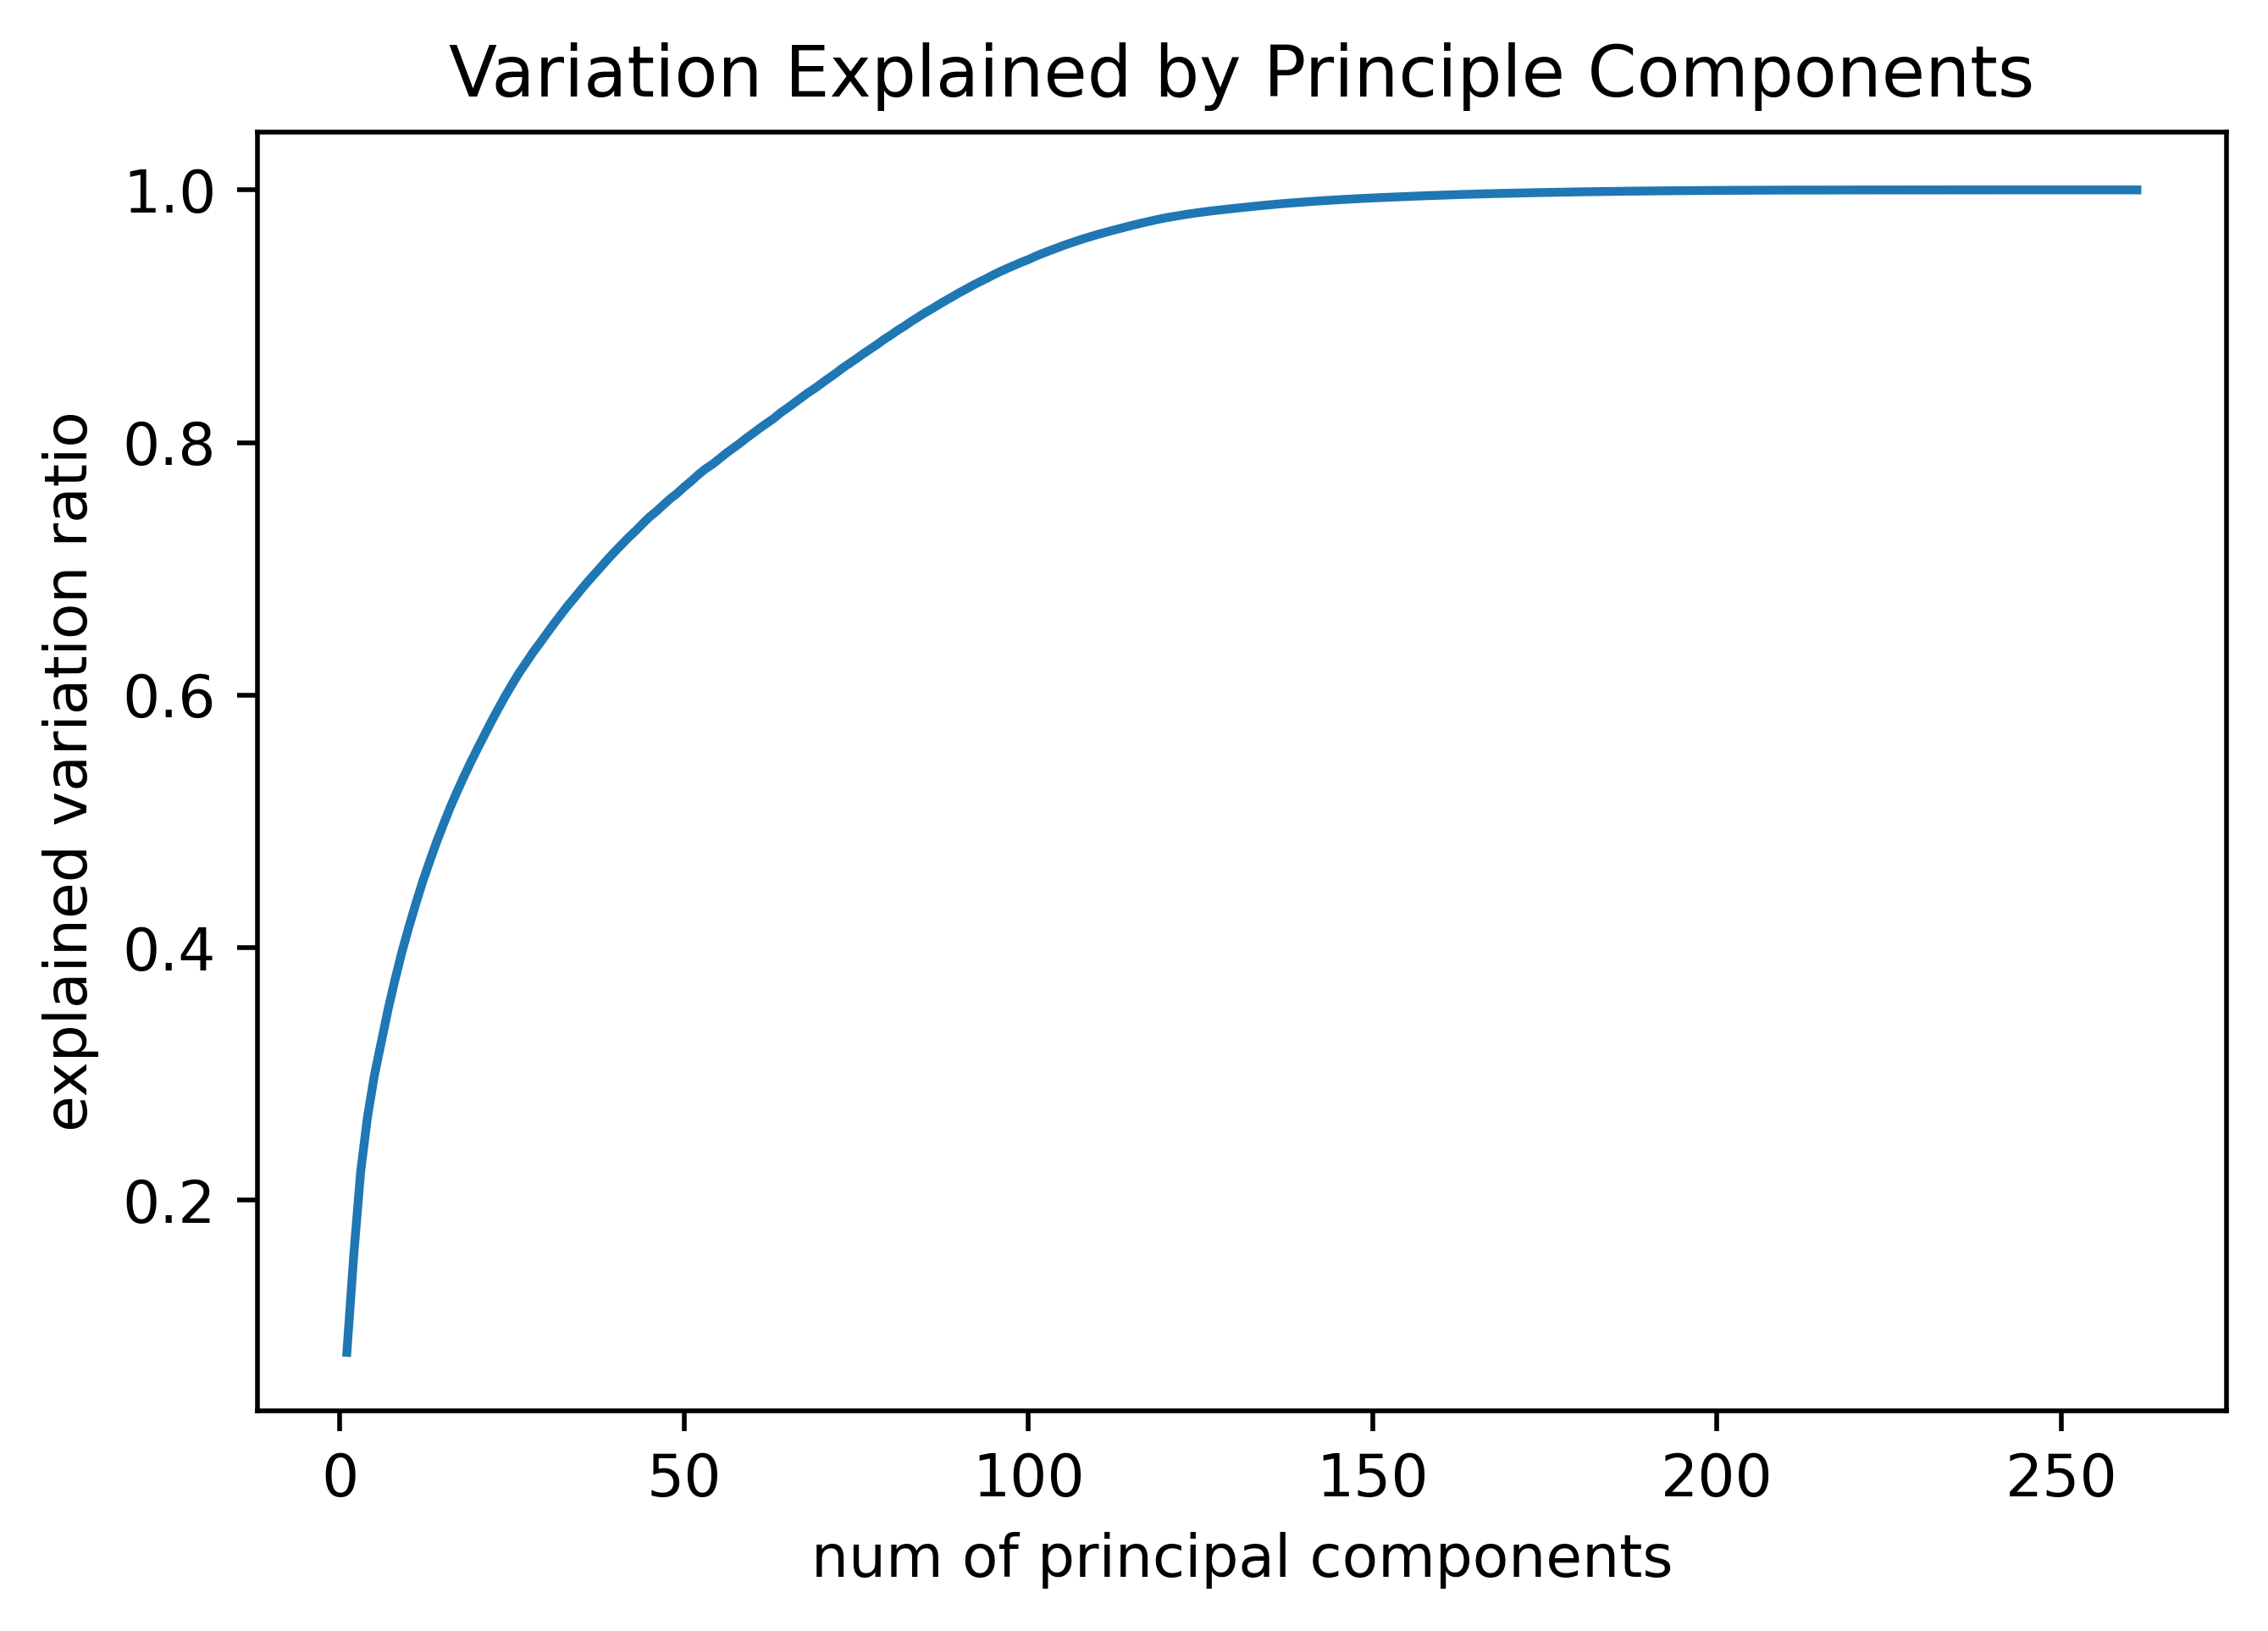

In [ ]:
y = lst_ratio
x = list(range(1, 262))
plt.figure(dpi=500)
plt.plot(x, y)
plt.xlabel('num of principal components')
plt.ylabel('explained variation ratio')
plt.title('Variation Explained by Principle Components')
plt.show()

0.8196721311475414

In [ ]:
!pip install imbalanced-learn

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import xgboost


skf = StratifiedKFold(n_splits=5, shuffle=True)
smt = SMOTE()
xgb = xgboost.XGBClassifier(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=7)

lst_acc_train = []
lst_acc_test = []

X_train = X_train_

i=0
for train_index, test_index in skf.split(X_train, y_train):
  i += 1
  X_train_fold, X_test_fold = X_train.iloc[train_index,:], X_train.iloc[test_index,:]
  y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

  X_train_smt, y_train_smt = smt.fit_resample(X_train_fold, y_train_fold)
  xgb.fit(X_train_smt, y_train_smt.squeeze())
  y_pred_train = xgb.predict(X_train_fold)
  y_pred_test = xgb.predict(X_test_fold)

  lst_acc_train.append(accuracy_score(y_train_fold, y_pred_train))
  lst_acc_test.append(accuracy_score(y_test_fold, y_pred_test))

  print('-'*20+f'{i} iteration'+'-'*20)
  print('XGB accuracy score for train: %.3f and test: %.3f' % (
        accuracy_score(y_train_fold, y_pred_train),
        accuracy_score(y_test_fold, y_pred_test)))
  print('Classification report for train:')
  print(classification_report(y_train_fold, y_pred_train))
  print('Classification report for test:')
  print(classification_report(y_test_fold, y_pred_test))
  print()

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import xgboost


scaler = StandardScaler()
pca = PCA(n_components='mle')
skf = StratifiedKFold(n_splits=10, shuffle=True)
smt = SMOTE()
xgb = xgboost.XGBClassifier(n_estimators=150, learning_rate=0.08, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=8)

X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)
xgb.fit(X_train_smt, y_train_smt.squeeze())
y_pred = xgb.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     77640
           1       0.80      0.99      0.88       729

    accuracy                           1.00     78369
   macro avg       0.90      0.99      0.94     78369
weighted avg       1.00      1.00      1.00     78369



In [ ]:
lst_acc_train = []
lst_acc_test = []

i=0
for train_index, test_index in skf.split(X_train, y_train):
  i += 1
  X_train_fold, X_test_fold = X_train.iloc[train_index,:], X_train.iloc[test_index,:]
  y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
  y_pred_train = xgb.predict(X_train_fold)
  y_pred_test = xgb.predict(X_test_fold)

  lst_acc_test.append(accuracy_score(y_train_fold, y_pred_train))
  lst_acc_train.append(accuracy_score(y_test_fold, y_pred_test))

  print('-'*20+f'{i} iteration'+'-'*20)
  print('XGB accuracy score for train: %.3f and test: %.3f' % (
        accuracy_score(y_train_fold, y_pred_train),
        accuracy_score(y_test_fold, y_pred_test)))
  print('Classification report for train:')
  print(classification_report(y_train_fold, y_pred_train))
  print('Classification report for test:')
  print(classification_report(y_test_fold, y_pred_test))
  print()

NameError: ignored

# 7. another appraoch


In [ ]:
item_ = item.copy()
for col in item_.columns[1:]:
  item_[col] = item_[col].astype('category')

In [ ]:
d = item.groupby('brand')['category'].value_counts().rename('cate_frequency').reset_index()
d= d.merge(d.groupby('brand')['cate_frequency'].sum().rename('cate_tot_frequency'), on='brand', how='left')
d['cate_relative_frequency'] = d['cate_frequency']/d['cate_tot_frequency']
d = d.merge(d.groupby('brand').agg(cate_gini=('cate_relative_frequency',gini_index)), on='brand', how='left')

ind = d.groupby('brand')['cate_frequency'].nlargest(1).reset_index(level=0).index

In [ ]:
brand = item.groupby('brand').agg(brand_nitem=('item_id', 'nunique'))
brand = brand.merge(d.iloc[ind,:], on='brand', how='left').drop(columns=["cate_frequency","cate_tot_frequency"])
brand = brand.rename(columns={'category':'brand_mfcategory', 'cate_relative_frequency':'brand_mfcategory_rl','cate_gini':'brand_category_gini'})
brand.iloc[:,2] = brand.iloc[:,2] .astype('category')

items = items.merge(item_, on='item_id', how='left').merge(brand, on='brand', how='left').drop(columns='brand')

In [ ]:
items_ = category2dummy(items)
items_.columns

Index(['item_id', 'item_ntransaction', 'item_recency_days', 'item_life_days',
       'item_popularity', 'item_tot_quantity', 'item_avg_quantity',
       'item_min_quantity', 'item_max_quantity', 'item_tot_sales_value',
       'item_avg_sales_value', 'item_min_sales_value', 'item_max_sales_value',
       'item_tot_other_discount', 'item_avg_other_discount',
       'item_min_other_discount', 'item_max_other_discount',
       'item_tot_coupon_discount', 'item_avg_coupon_discount',
       'item_min_coupon_discount', 'item_max_coupon_discount',
       'item_avg_unit_price', 'item_min_unit_price', 'item_max_unit_price',
       'brand_type', 'category', 'brand_nitem', 'brand_mfcategory_rl',
       'brand_category_gini', 'brand_mfcategory_Bakery',
       'brand_mfcategory_Dairy, Juices & Snacks',
       'brand_mfcategory_Flowers & Plants', 'brand_mfcategory_Garden',
       'brand_mfcategory_Grocery', 'brand_mfcategory_Meat',
       'brand_mfcategory_Miscellaneous', 'brand_mfcategory_Natural Pr

In [ ]:
x_train = train.drop(columns=['redemption_status'])
y_train = train['redemption_status']

In [ ]:
def mergedrop(df):
  df_ = df.merge(camp_, on='campaign_id', how='left').merge(coup_, on='coupon_id', how='left').merge(cust_, on='customer_id', how='left').merge(items_, on='item_id')\
                                                                                                        .drop(columns=['id','campaign_id','coupon_id','customer_id', 'item_id'])
  return df_

In [ ]:
coupon_item

,coupon_id,item_id
0,105,37
1,107,75
2,494,76
3,522,77
4,518,77
...,...,...
92658,32,69268
92659,32,68502
92660,32,68612
92661,33,71390


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import xgboost


scaler = StandardScaler()
pca = PCA(n_components='mle')
skf = StratifiedKFold(n_splits=10, shuffle=True)
xgb = xgboost.XGBClassifier(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=10)

lst_roc_train = []
lst_roc_test = []
# lst_acc_train = []
# lst_acc_test = []

i=0
for train_index, test_index in skf.split(x_train, y_train):
  i += 1
  df_train = train.iloc[train_index,:]
  df_test = train.iloc[test_index,:]

  train_aug = df_train.merge(coupon_item, on='coupon_id')
  test_aug = df_test.merge(coupon_item, on='coupon_id')

  x_train_aug = train_aug.drop(columns=['redemption_status'])
  y_train_aug = train_aug['redemption_status']
  x_test_aug = test_aug.drop(columns=['redemption_status'])
  y_test_aug = test_aug['redemption_status']

  X_train_aug = mergedrop(x_train_aug)
  X_test_aug = mergedrop(x_test_aug)

  xgb.fit(X_train_aug, y_train_aug.squeeze())
  y_aug_pred_train = pd.Series(xgb.predict(X_train_aug)).rename('prediction')
  y_aug_pred_test = pd.Series(xgb.predict(X_test_aug)).rename('prediction')

  y_train_pred = pd.concat([train_aug, y_aug_pred_train], axis=1).groupby('id')['prediction'].mean().to_numpy()
  y_train = pd.concat([train_aug, y_aug_pred_train], axis=1).groupby('id')['redemption_status'].mean().to_numpy()

  y_test_pred = pd.concat([test_aug, y_aug_pred_test], axis=1).groupby('id')['prediction'].mean().to_numpy()
  y_test = pd.concat([test_aug, y_aug_pred_test], axis=1).groupby('id')['redemption_status'].mean().to_numpy()

  print('-'*20+f'{i} iteration'+'-'*20)
  print(f'ROC score of train:{roc_auc_score(y_train, y_train_pred)}')
  print(f'ROC score of train:{roc_auc_score(y_test, y_test_pred)}')
  lst_roc_train.appdend(roc_auc_score(y_train, y_train_pred))
  lst_roc_test.append(roc_auc_score(y_test, y_test_pred))

  # print('XGB accuracy score for train: %.3f and test: %.3f' % (
  #       accuracy_score(y_train, y_pred_train),
  #       accuracy_score(y_test, y_pred_test)))
  # print('Classification report for train:')
  # print(classification_report(y_train, y_pred_train))
  # print('Classification report for test:')
  # print(classification_report(y_test, y_pred_test))
  # print()
  # lst_acc_train.append(accuracy_score(y_train, y_pred_train))
  # lst_acc_test.append(accuracy_score(y_test, y_pred_test))